In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.tabular import *
import numpy as np
import warnings; 
warnings.filterwarnings("ignore") 
import os 
os.environ['OMP_NUM_THREADS'] = '8' # speed up using 8 cpu

In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')

In [3]:
# keep 30',45'
train = train[train['Delivery_Time']!='120 minutes'] 
train = train[train['Delivery_Time']!='80 minutes'] 
train = train[train['Delivery_Time']!='20 minutes'] 
train = train[train['Delivery_Time']!='10 minutes'] 
train = train[train['Delivery_Time']!='65 minutes']

In [4]:
# Extract all cuisines
temp = train['Cuisines'].unique()
biglist = []
for i in temp:
    for j in i.split(', '):
        biglist.append(j)
shortlist = list(set(biglist))
# prepare cuisine encoding
for i in shortlist:
    train[i] = 0
    test[i] = 0

In [5]:
# Featurizing train
for i in range(0,len(train)):
    temp = train.iloc[i,2]
    temp2 = temp.split(', ')
    for j in range(0,len(temp2)):
        temp3 = temp2[j]
        for k in range(0,len(train.columns)):
                if temp3 == train.columns[k]:
                        train.iloc[i,k] = 1
                        #print(temp3, k)

In [6]:
# Featurizing test
for i in range(0,len(test)):
    temp = test.iloc[i,2]
    temp2 = temp.split(', ')
    for j in range(0,len(temp2)):
        temp3 = temp2[j]
        for k in range(0,len(test.columns)):
                if temp3 == test.columns[k]:
                        test.iloc[i,k] = 1
                        #print(temp3, k)

In [7]:
# Feature engineering
# 1. remove the currency sign and convert to integer
train['Average_Cost'] = train['Average_Cost'].replace( '[\₹)]','', regex=True )
test['Average_Cost'] = test['Average_Cost'].replace( '[\₹)]','', regex=True )
train['Minimum_Order'] = train['Minimum_Order'].replace( '[\₹)]','', regex=True )
test['Minimum_Order'] = test['Minimum_Order'].replace( '[\₹)]','', regex=True )
train['Average_Cost'] = train['Average_Cost'].str.replace("for", "250") # correct typo
train['Average_Cost'] = train['Average_Cost'].str.replace(",", "")
train['Average_Cost'] = train['Average_Cost'].astype(int)
test['Average_Cost'] = test['Average_Cost'].str.replace(",", "")
test['Average_Cost'] = test['Average_Cost'].astype(int)
train['Minimum_Order'] = train['Minimum_Order'].astype(int)
test['Minimum_Order'] = test['Minimum_Order'].astype(int)
# 2. extract number of cuisine
train['sub'] = train['Cuisines'].str.count(', ') + 1
test['sub'] = test['Cuisines'].str.count(', ') + 1
# 3. clean rating
train['Rating'] = train['Rating'].str.replace("-", "3.5")
train['Rating'] = train['Rating'].str.replace("NEW", "3.5")
train['Rating'] = train['Rating'].str.replace("Opening Soon", "3.5")
train['Rating'] = train['Rating'].str.replace("Temporarily Closed", "3.5")
test['Rating'] = test['Rating'].str.replace("-", "3.5")
test['Rating'] = test['Rating'].str.replace("NEW", "3.5")
test['Rating'] = test['Rating'].str.replace("Opening Soon", "3.5")
train['Rating'] = train['Rating'].str.replace(".", "")
test['Rating'] = test['Rating'].str.replace(".", "")
train['Rating'] = train['Rating'].astype(int)
test['Rating'] = test['Rating'].astype(int)
# 4. clean votes
train['Votes'] = train['Votes'].str.replace("-", "0")
train['Votes'] = train['Votes'].astype(int)
test['Votes'] = test['Votes'].str.replace("-", "0")
test['Votes'] = test['Votes'].astype(int)
# 5. clean Reviews
train['Reviews'] = train['Reviews'].str.replace("-", "0")
train['Reviews'] = train['Reviews'].astype(int)
test['Reviews'] = test['Reviews'].str.replace("-", "0")
test['Reviews'] = test['Reviews'].astype(int)
# 6. Location encoding
#train = pd.get_dummies(train, columns=['Location'])
#test = pd.get_dummies(test, columns=['Location'])

In [8]:
# cleaning dataset
del train['Cuisines']
del test['Cuisines']

In [9]:
# target encoding
train['Delivery_Time'].replace('30 minutes', '1', inplace=True)
train['Delivery_Time'].replace('45 minutes', '2', inplace=True)
train['Delivery_Time'] = train['Delivery_Time'].astype(int)

In [10]:
dep_var='Delivery_Time'
col = test.columns
procs= [Categorify,Normalize]
data = (TabularList.from_df(train, cat_names=col , procs=procs,)
                .split_subsets(train_size=0.8, valid_size=0.2, seed=34)
                .label_from_df(cols=dep_var)
                .databunch())
data.show_batch(rows=10)

Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Modern Indian,Bar Food,Kashmiri,Assamese,Lebanese,Mishti,Chinese,Korean,Spanish,North Indian,Juices,Seafood,Italian,Andhra,Sri Lankan,Bakery,Mughlai,Tibetan,Iranian,Tex-Mex,Steak,Awadhi,Coffee,Sushi,European,Paan,Desserts,North Eastern,Tea,Hyderabadi,Frozen Yogurt,Charcoal Chicken,Belgian,Finger Food,Poké,Bangladeshi,Thai,Mexican,Raw Meats,Arabian,Wraps,Mithai,Hot dogs,Ice Cream,Kebab,American,Bubble Tea,Nepalese,Tamil,Lucknowi,BBQ,Kerala,Malaysian,Goan,Fast Food,Burmese,Israeli,Indian,Gujarati,Mangalorean,Rajasthani,Roast Chicken,French,Bohri,Naga,African,Cantonese,Salad,Mediterranean,Continental,Konkan,Parsi,Turkish,South Indian,Beverages,Cafe,Bihari,Rolls,Momos,Pizza,Portuguese,Middle Eastern,Asian,Odia,South American,Afghan,German,Sandwich,Maharashtrian,Biryani,Greek,Street Food,Japanese,Brazilian,Chettinad,Indonesian,Vietnamese,Burger,Healthy Food,Malwani,Bengali,sub,target
ID_4154,"Noorkhan Bazaar, Malakpet, Hyderabad",100,50,39,819,153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
ID_6209,"Mico Layout, Stage 2, BTM Layout,Bangalore",150,50,41,261,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
ID_1784,"Sector 1, Noida",100,50,32,8,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
ID_2420,"Sector 1, Noida",200,50,35,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
ID_427,"Delhi Administration Flats, Timarpur",100,50,34,207,107,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
ID_4820,"Mico Layout, Stage 2, BTM Layout,Bangalore",200,50,32,5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
ID_2429,"Sector 1, Noida",100,50,38,67,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
ID_5252,"Laxman Vihar Industrial Area, Sector 3A, Gurgoan",250,50,39,396,169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2
ID_4720,Delhi Cantt.,400,50,41,254,205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,2
ID_8216,"Mico Layout, Stage 2, BTM Layout,Bangalore",200,50,40,388,176,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2


In [11]:
learn = tabular_learner(data, layers=[200,100],metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


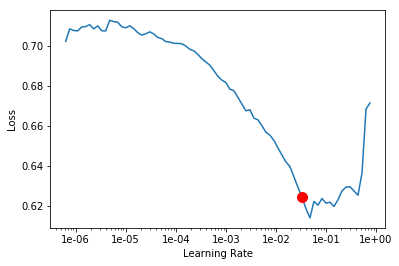

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit(3,lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.434999,0.392446,0.820258,01:07
1,0.146982,0.473700,0.795928,01:06
2,0.070654,0.495524,0.835154,01:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


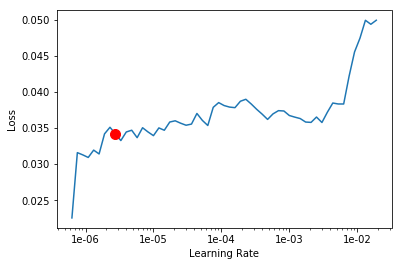

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(5,max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.038297,0.462173,0.839623,01:10
1,0.037442,0.466501,0.836644,01:08
2,0.038617,0.463811,0.836644,01:08
3,0.035349,0.465093,0.836147,01:08
4,0.035063,0.465957,0.836644,01:08


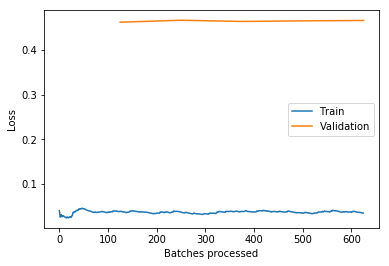

In [16]:
learn.recorder.plot_losses()

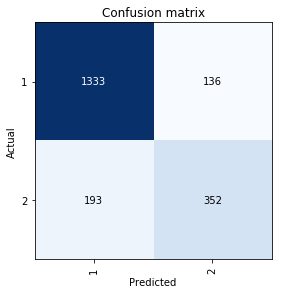

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [18]:
row = test.iloc[0]
learn.predict(row)[0]

Category 1

In [19]:
sub = pd.read_excel('Sample_Submission.xlsx')
sub['Delivery_Time'] = '30 minutes'

In [20]:
for i in range(0,len(test)):
    row = test.iloc[i]
    sub.iloc[i,0]=learn.predict(row)[0]
    


In [21]:
# target re-encoding
sub['Delivery_Time'] = sub['Delivery_Time'].astype(str)
sub['Delivery_Time'].replace('1', '30 minutes', inplace=True)
sub['Delivery_Time'].replace('2', '45 minutes', inplace=True)


In [22]:
sub.to_excel("baseline_model_v6_2.xlsx", index=None)

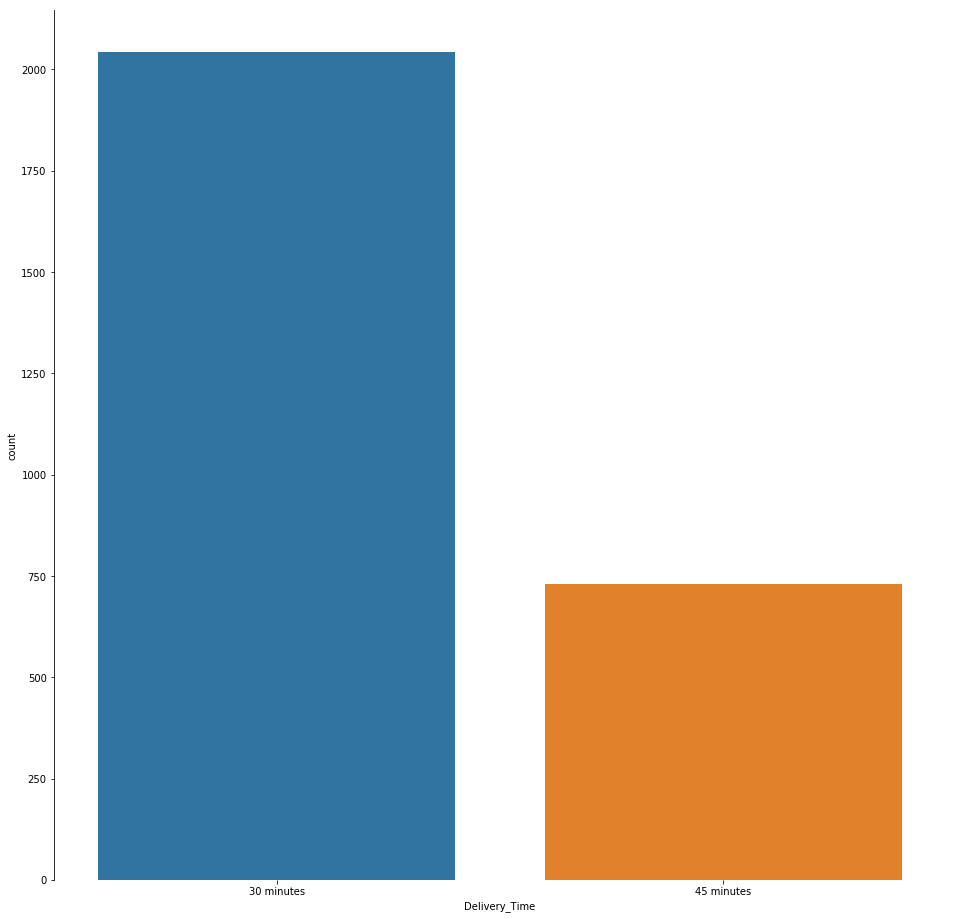

In [23]:
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.countplot(x="Delivery_Time", data=sub, label="Label count")
sns.despine(bottom=True)